In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_metadata(file_path):
    with open(file_path, 'rb') as file:
        metadata = pickle.load(file)
    return metadata


def load_states_in_chunks(file_path, chunk_size):
    with open(file_path, 'rb') as file:
        while True:
            try:
                chunk = pickle.load(file)
                for i in range(0, len(chunk), chunk_size):
                    yield chunk[i:i + chunk_size]
            except EOFError:
                break

pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\carla\AppData\Local\Temp\ipykernel_20056\1034127964.py:26: RuntimeWarning: divide by zero encountered in log10
  states_biomass.append(np.log10(sum([plant.r for plant in plants])))
C:\Users\carla\AppData\Local\Temp\ipykernel_20056\1034127964.py:27: RuntimeWarning: divide by zero encountered in log10
  states_density.append(np.log10(len(plants)))


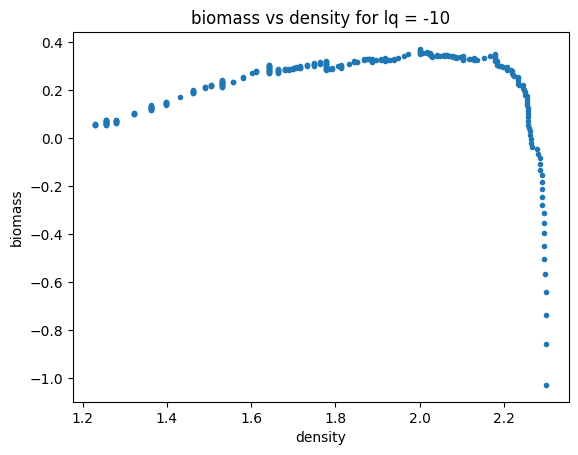

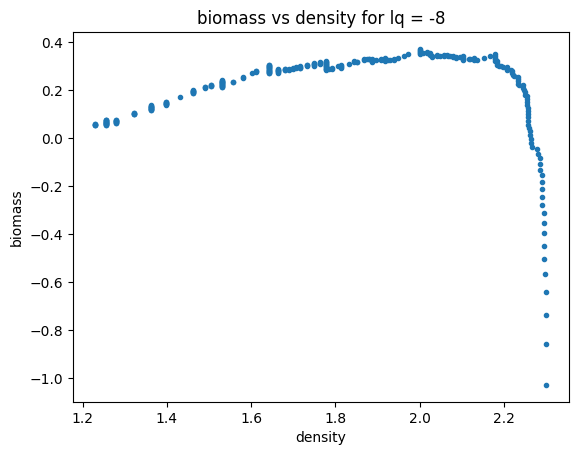

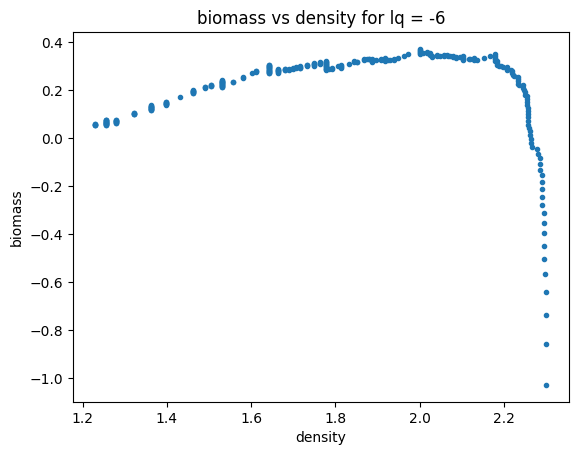

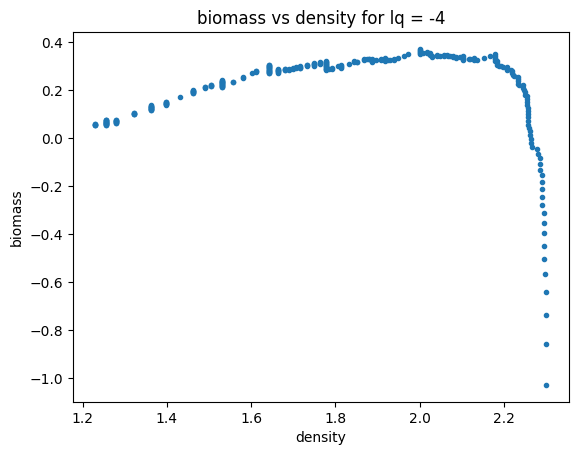

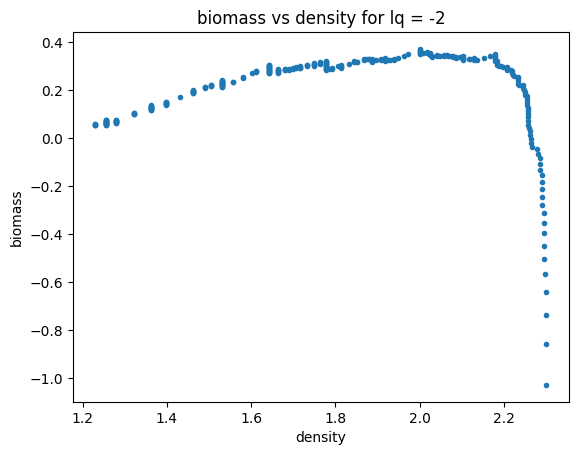

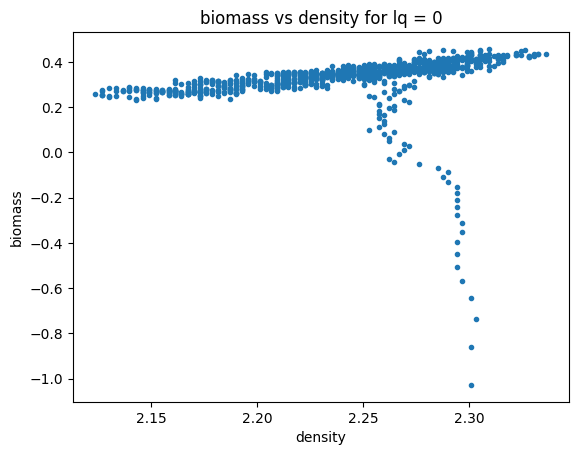

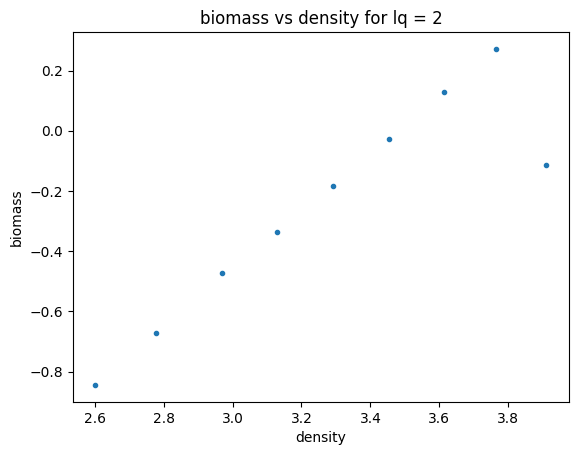

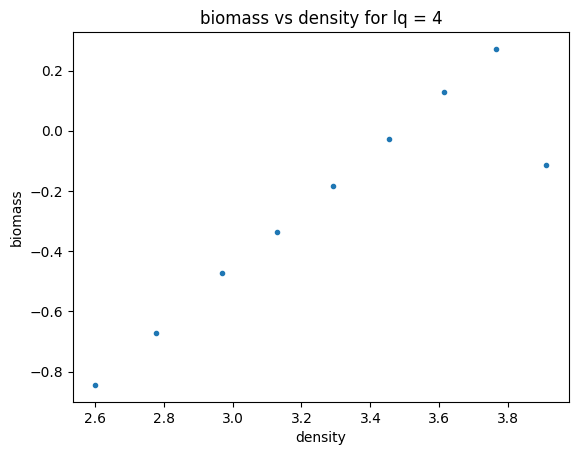

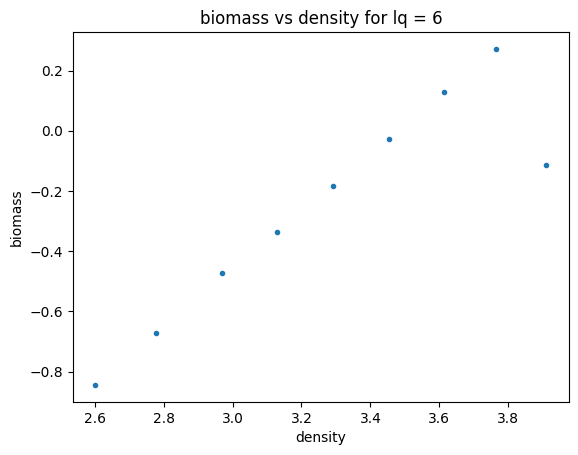

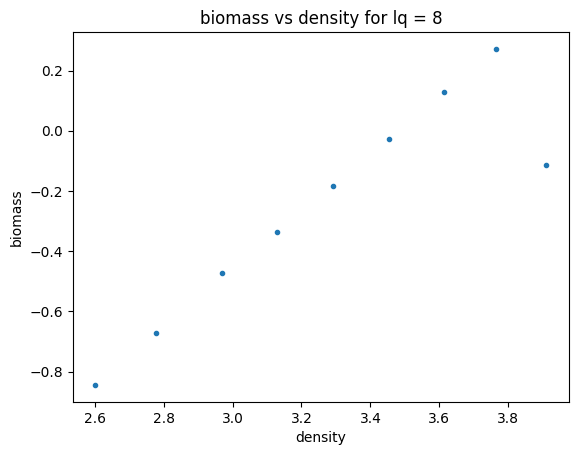

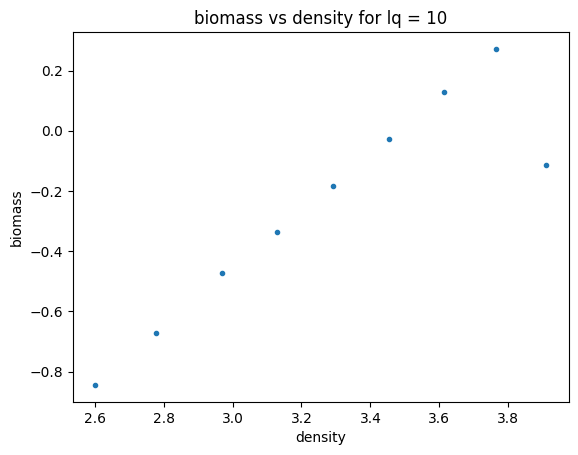

In [2]:
lqs = np.arange(-10, 11, 2)
for lq in lqs:
    surfix = 'lq' + str(lq)
    file_path_metadata = f'Data\metadata_{surfix}.pkl'
    file_path_states = f'Data\states_{surfix}.pkl'

    metadata = load_metadata(file_path_metadata)

    total_states = n_iter = metadata['n_iter']
    chunk_size = metadata['chunk_size']

    # Initialize an empty list to hold all the QuadTree objects
    states = []

    i = 1
    for chunk in load_states_in_chunks(file_path_states, chunk_size):
        last_chunk_loaded = min(chunk_size * i, n_iter)
        states.extend(chunk)
        i += 1
    
    states_biomass = []
    states_density = []

    for state in states:
        plants = [point.data for point in state.all_points()]
        states_biomass.append(np.log10(sum([plant.r for plant in plants])))
        states_density.append(np.log10(len(plants)))
        
    plt.figure()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('density')
    plt.ylabel('biomass')
    plt.title(f'biomass vs density for lq = {lq}')
    plt.plot(states_density, states_biomass, '.')